# Tiltmeter ALL Overview

## Import Libraries

In [1]:
import os
import obspy
import matplotlib.pyplot as plt
import pandas as pd

from numpy import arange, linspace, sqrt, diff, nan, gradient, nanmax, nanmean
from pandas import read_csv, DataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.ma import filled, isMaskedArray, masked
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from obspy import UTCDateTime
from pathlib import Path

from andbro__querrySeismoData import __querrySeismoData
from andbro__get_seconds import __get_seconds
from andbro__readYaml import __readYaml
from andbro__get_timeaxis import __get_timeaxis

In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

## Define Functions

In [4]:
from functions.plot_all_tilt import __plot_all_tilt

## Configurations

In [3]:
## configurations
config={}

# path = "/home/andbro/Desktop/tiltmeter/"
# path2 = '/home/andbro/Desktop/tiltmeter/WETTER/*ex'
# config['name'] = 'tiltmeter'
# config['set_filter'] = 'n'

## decide to store figures
config['save'] = True

## set time period
config['tbeg'] = UTCDateTime("2021-03-10 00:00")
config['tend'] = UTCDateTime("2023-05-31 00:00")




## specify paths
config['path_to_wromy'] = archive_path+"romy_archive/"

config['path_to_data'] = data_path+"TiltmeterDataBackup/Tilt_downsampled/"

config['path_to_figs'] = root_path+"Documents/ROMY/tiltmeter/figures/"


## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter.conf")

## correction of offset (e.g. reset mass)
# offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_steps.yml")
offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_offsets.yml")

## correction for temperature trends
## based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")
## based on WSX
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction_new.yml")



## Load Tiltmeter Data

In [5]:
from andbro__read_sds import __read_sds

In [6]:
ROMYT0 = __read_sds(config['path_to_data'], "BW.ROMYT..MA*", config['tbeg'], config['tend'])

ROMYT0 = ROMYT0.sort()

ROMYT0 = ROMYT0.merge()

# ROMYT0 = ROMYT0.resample(1.0, no_filter=False)

In [7]:
TROMY0 = __read_sds(config['path_to_data'], "BW.TROMY..MA*", config['tbeg'], config['tend'])

TROMY0 = TROMY0.sort()

TROMY0 = TROMY0.merge()

# TROMY0 = TROMY0.resample(1.0, no_filter=False)

In [8]:
BROMY0 = __read_sds(config['path_to_data'], "BW.DROMY..LA*", config['tbeg'], config['tend'])

BROMY0 = BROMY0.sort()

BROMY0 = BROMY0.merge()

## Correct for known offsets

In [9]:
from functions.correct_offsets import __correct_offsets

In [10]:
TROMY = __correct_offsets(TROMY0, offset_correction['TROMY'], plot=False)
ROMYT = __correct_offsets(ROMYT0, offset_correction['ROMYT'], plot=False)
BROMY = __correct_offsets(BROMY0, offset_correction['BROMY'], plot=False)

/home/brotzer/notebooks/Tilt/functions/plot_all_tilt.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[NN-1].set_xticklabels(tcklbls)


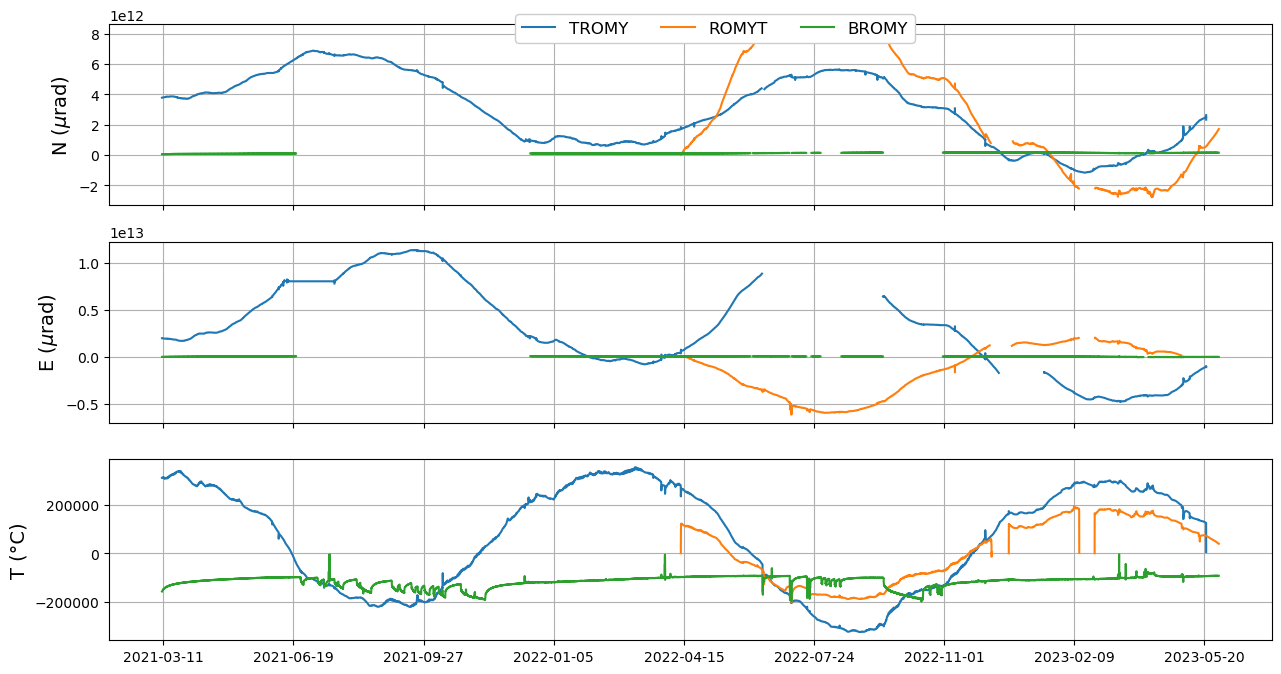

In [11]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY);

## Correct polarity of TROMY E component

In [12]:
TROMY.select(channel="*E")[0].data *= -1

## Covert Data Counts to Rad

In [13]:
from functions.converstion_to_tilt import __conversion_to_tilt

In [14]:
TROMY = __conversion_to_tilt(TROMY, confTilt['TROMY'])
ROMYT = __conversion_to_tilt(ROMYT, confTilt['ROMYT'])
BROMY = __conversion_to_tilt(BROMY, confTilt['BROMY'])

  -> converted data of TROMY
  -> converted data of ROMYT
  -> converted data of DROMY


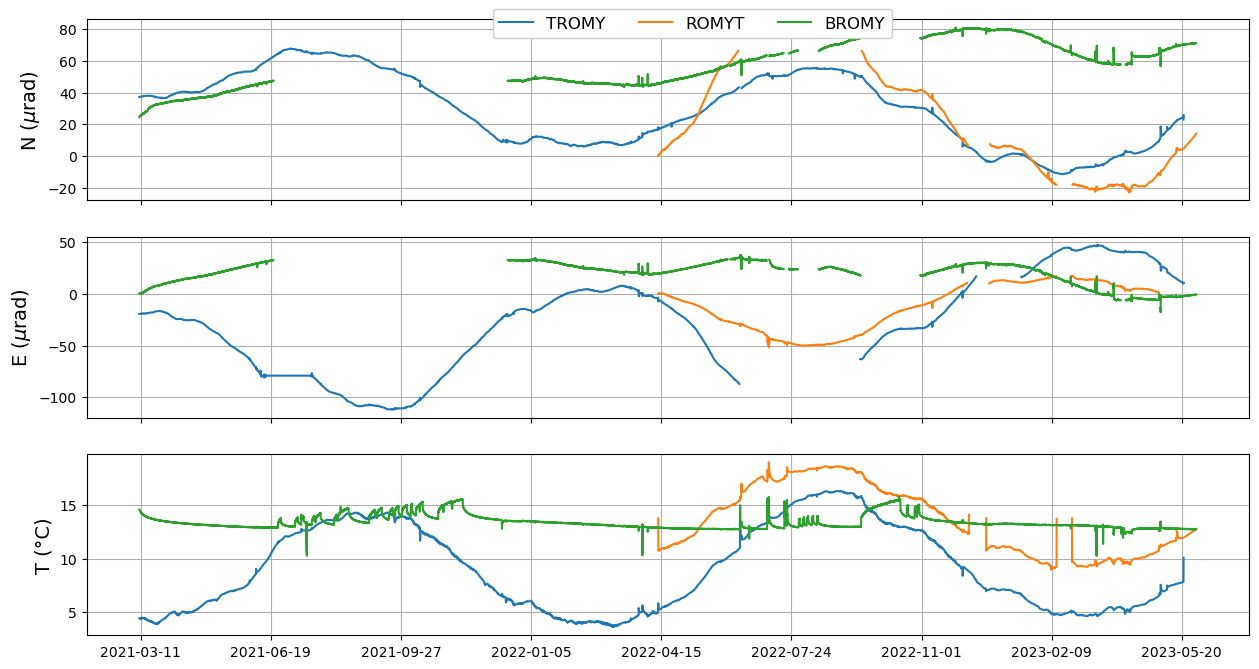

In [15]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY);

if config['save']:
    fig.savefig(config['path_to_figs']+"TILT_all_overview_converted.png", format="png", dpi=200, bbox_inches='tight')

## Correct for Linear Temperature Trend

In [16]:
from functions.correct_temperature_trend import __correct_temperature_trend

In [17]:
## apply correction model
# TROMY = __correct_temperature_trend(TROMY, temperature_correction['TROMY'])
# ROMYT = __correct_temperature_trend(ROMYT, temperature_correction['ROMYT'])
# # BROMY = __correct_temperature_trend(BROMY, temperature_correction['BROMY'])

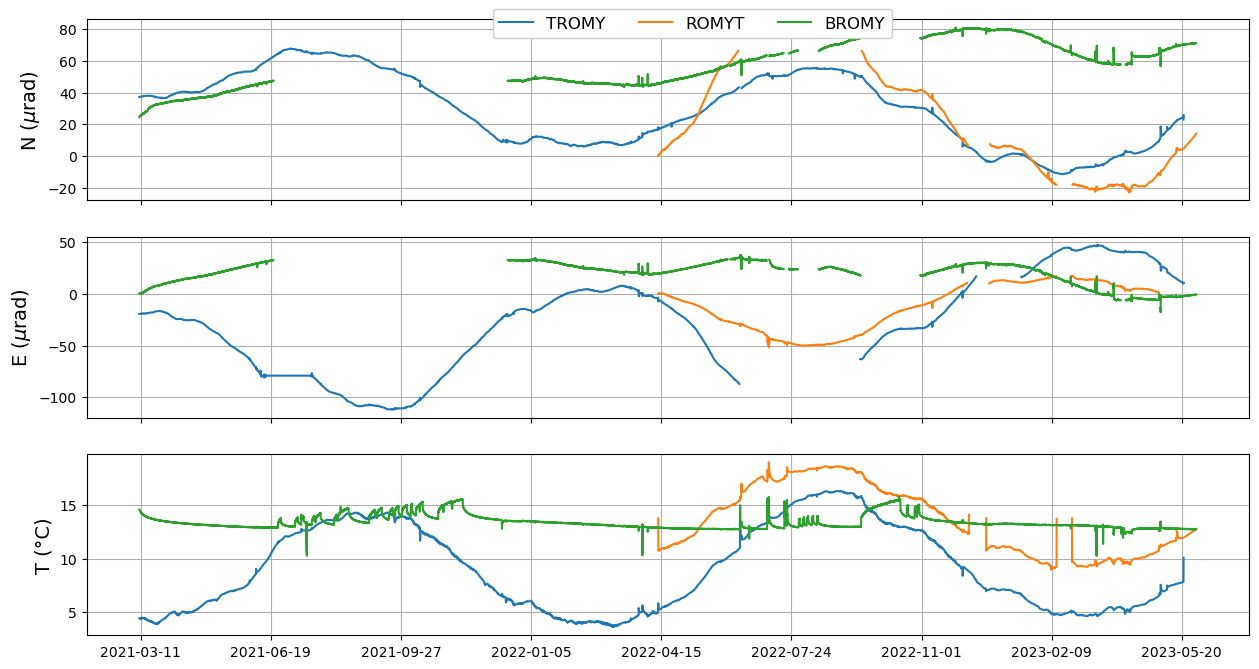

In [18]:
# fig = __plot_all_tilt(TROMY, ROMYT, BROMY);

# if config['save']:
#     fig.savefig(config['path_to_figs']+"TILT_all_overview_Tcorrected.png", format="png", dpi=200, bbox_inches='tight')

## Tilt Reset at Start

In [19]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= nanmean(tr.data[:200])

In [20]:
## Reset ROMYT with TROMY
romyt_utc = str(ROMYT[0].times("utcdatetime")[0].date)
tromy_utc = [str(t.date) for t in TROMY[0].times("utcdatetime")]

idx = tromy_utc.index(romyt_utc)

for tr in ROMYT:
    if "N" in tr.stats.channel:
        tr.data += TROMY.select(channel="*N")[0].data[idx]
    if "E" in tr.stats.channel:
        tr.data += TROMY.select(channel="*E")[0].data[idx]


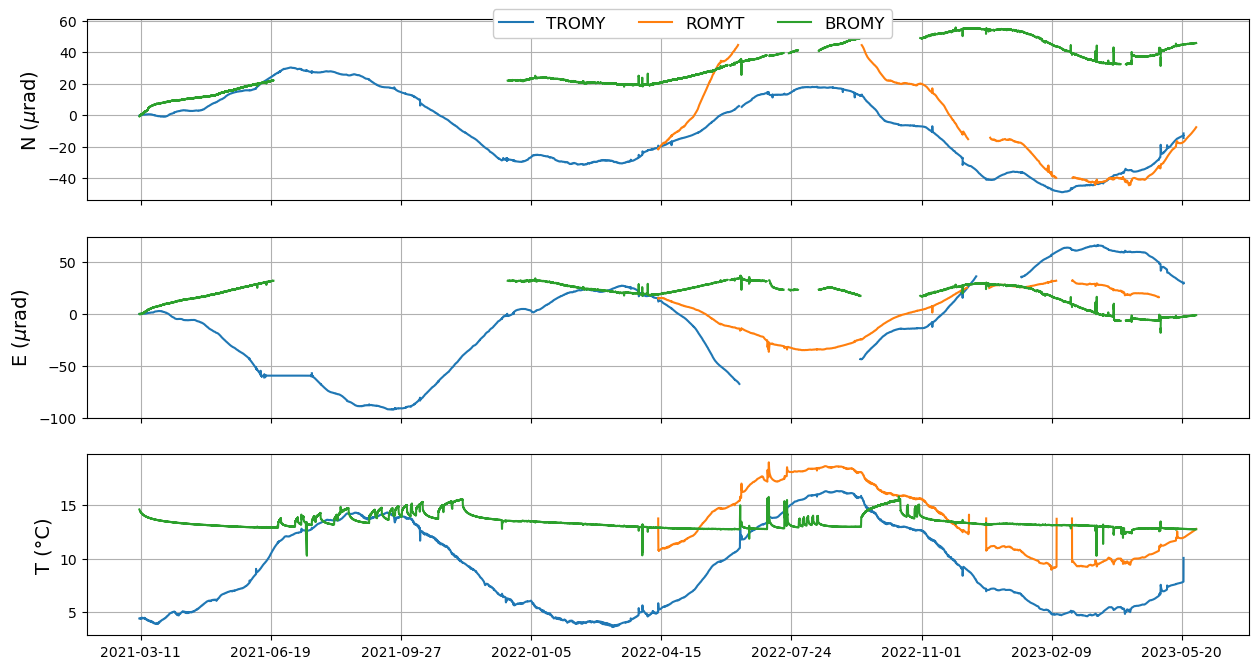

In [21]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY)

if config['save']:
    fig.savefig(config['path_to_figs']+"TILT_all_overview_reset.png", format="png", dpi=200, bbox_inches='tight')

In [22]:
86400*180

15552000

## Add WROMY Data

In [23]:
from andbro__load_WROMY_stream import __load_wromy_stream

In [24]:
# ws5 = __load_wromy_stream(config['path_to_wromy'], "BW.WROMY..WS5", config['tbeg'], config['tend'])

In [25]:
# from numpy import isfinite, array
# import numpy.ma as ma

# arr = ws5.select(channel="*T")[0].data
# # arr = array([1,2,3,nan,3,4])
# # mask = isfinite(arr)
# # ma_arr = ma.masked_array(arr, mask=mask)

# ma_arr = ma.masked_invalid(arr)
# ws5.select(channel="*T")[0].data = ma.masked_invalid(arr)

# plt.plot(ma_arr)

### Load FURT Data

In [26]:
from andbro__load_FURT_stream import __load_furt_stream

In [27]:
# furt = __load_furt_stream(config['tbeg'], config['tend'])

# Plotting Movement

## Tilt Vector

In [28]:
def __get_movement(N, E, Twin=3600):

    from numpy import median, sqrt, arctan, degrees, mod, array, append, rad2deg, nan, ma, deg2rad

    dt = N[0].stats.delta
#     t1 = N[0].stats.starttime
    t1 = 0

    Ndata = N[0].data
    Edata = E[0].data

    if ma.is_masked(Ndata):
        Ndata = ma.filled(Ndata, fill_value=nan)
    if ma.is_masked(Edata):
        Edata = ma.filled(Edata, fill_value=nan)

    vnorm, vdir, timeline = [], [], []
    while (t1 + Twin) < N[0].stats.npts*dt:

        Nmed = median(Ndata[int(t1/dt):int((t1+Twin)/dt)])
        Emed = median(Edata[int(t1/dt):int((t1+Twin)/dt)])


        vnorm.append(sqrt(Nmed**2 + Emed**2))

        if Nmed > 0 and Emed > 0:
            vdir.append(90-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed > 0:
            vdir.append(90+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed < 0:
            vdir.append(270-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed > 0 and Emed < 0:
            vdir.append(270+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        else:
            vdir.append(nan)

        t1 += Twin/2

        timeline.append(t1)

    time_offset = abs(UTCDateTime("2021-03-10") - N[0].stats.starttime)
    # time_offset = N[0].stats.starttime.julday
    timeline = (array(timeline) + time_offset)/3600 /24 ## in days

    return timeline, array(vdir), array(vnorm)

In [29]:
twindow = 3600  ## seconds

tromy_timeline, tromy_dir, tromy_norm = __get_movement(TROMY.select(channel="*N"), TROMY.select(channel="*E"), Twin=twindow)
romyt_timeline, romyt_dir, romyt_norm = __get_movement(ROMYT.select(channel="*N"), ROMYT.select(channel="*E"), Twin=twindow)
bromy_timeline, bromy_dir, bromy_norm = __get_movement(BROMY.select(channel="*N"), BROMY.select(channel="*E"), Twin=twindow)

tromy_norm *= 1e3 # convert to milli rad
romyt_norm *= 1e3 # convert to milli rad
bromy_norm *= 1e3 # convert to milli rad

In [30]:
def __makeplot_normal_vector_movement(set1, set2, set3):

    from numpy import deg2rad, arange
    import matplotlib as mpl

    vdirH, vnormH, vtimelineH = set1
    vdirV, vnormV, vtimelineV = set2
    vdirB, vnormB, vtimelineB = set3

    time_min = min([min(tromy_timeline), min(romyt_timeline), min(bromy_timeline)])
    time_max = max([max(tromy_timeline), max(romyt_timeline), max(bromy_timeline)])

    #-- Plot... ------------------------------------------------
    fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(15,5))

    font=12

    cmap = mpl.colormaps['viridis']
    # cmap = mpl.colormaps['viridis'].resampled(len(cs)+1)


    ## convert degrees to radians for plotting as polar!
    p1 = ax[0].scatter(deg2rad(vdirH), vnormH, c=vtimelineH, cmap=cmap, vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)
    p2 = ax[1].scatter(deg2rad(vdirV), vnormV, c=vtimelineV, cmap=cmap, vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)
    p3 = ax[2].scatter(deg2rad(vdirB), vnormB, c=vtimelineB, cmap=cmap, vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)

    # cbar1 = plt.colorbar(p1, ax=ax[0], pad=0.1, orientation='horizontal')
    # cbar1.set_label('Time in days', rotation=0, fontsize=font, labelpad=10)

    # cbar2 = plt.colorbar(p2, ax=ax[1],  pad=0.1, orientation='horizontal')
    # cbar2.set_label('Time in days', rotation=0, fontsize=font, labelpad=10)

    # cbar3 = plt.colorbar(p3, ax=ax[2],  pad=0.1, orientation='horizontal')
    # cbar3.set_label('Time in days', rotation=0, fontsize=font, labelpad=10)

    cbar3 = plt.colorbar(p3, ax=ax,  pad=0.1, orientation='horizontal', fraction=0.1, shrink=5)
    # cbar3.set_label('Time from 2021-03-10 (days)', rotation=0, fontsize=font, labelpad=10)

    ## set new colorbar ticks
    ref_time = UTCDateTime("2021-03-10")
    nticks = [str((ref_time+time_min+t*86400).date) for t in cbar3.get_ticks()]
    cbar3.set_ticklabels(nticks)

# #     ax[0].set_ylim(min(vnormH)-0.1*min(vnormH), max(vnormH)+0.05*max(vnormH))
# #     ax[1].set_ylim(min(vnormV)-0.05*min(vnormV), max(vnormV)+0.01*max(vnormV))

    for i in range(3):
        ax[i].set_ylim(0, 0.1)
        ax[i].set_theta_zero_location('N')
        ax[i].set_theta_direction(-1)

    ax[0].text(deg2rad(25),0.12,r"(mrad)")
    ax[0].set_rgrids(arange(0.02, 0.12, 0.02), angle=25., zorder=0)

    ax[1].text(deg2rad(250),0.13,r"(mrad)")
    ax[1].set_rgrids(arange(0.02, 0.12, 0.02), angle=250., zorder=0)

    ax[2].text(deg2rad(205),0.12,r"(mrad)")
    ax[2].set_rgrids(arange(0.02, 0.12, 0.02), angle=205., zorder=0)

    ax[0].set_title("TROMY",fontsize=font)
    ax[1].set_title("ROMYT",fontsize=font)
    ax[2].set_title("BROMY",fontsize=font)

    plt.show();
    return fig

/tmp/ipykernel_3216534/1216405612.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar3.set_ticklabels(nticks)


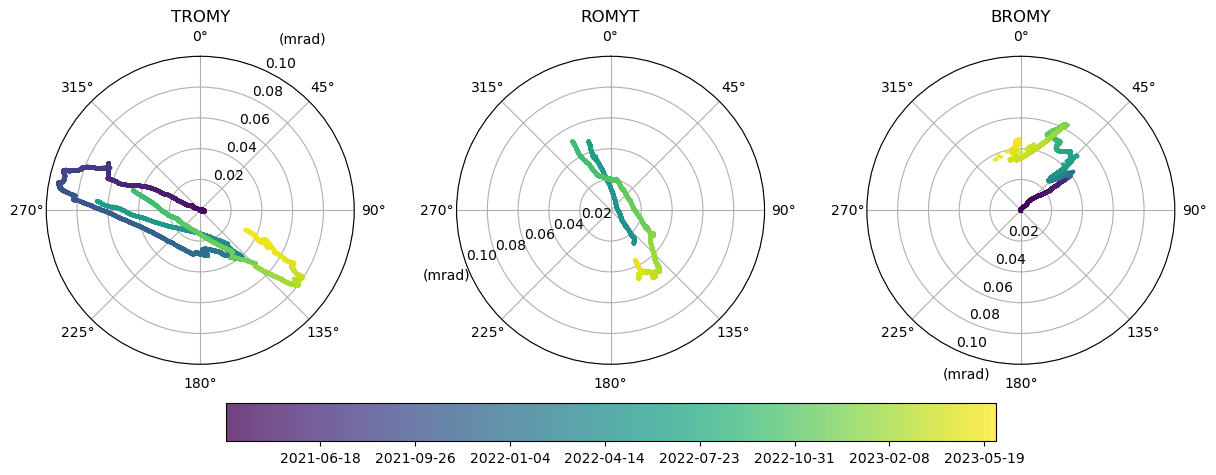

In [31]:
set1 = (tromy_dir, tromy_norm, tromy_timeline)
set2 = (romyt_dir, romyt_norm, romyt_timeline)
set3 = (bromy_dir, bromy_norm, bromy_timeline)


fig = __makeplot_normal_vector_movement(set1, set2, set3)

if config['save']:
    fig.savefig(config['path_to_figs']+"TILT_all_overview_vectors.png", format="png", dpi=200, bbox_inches='tight')

In [32]:
def __makeplot_vector(set1, set2, set3):

    from numpy import deg2rad
    import matplotlib as mpl

    vdirH, vnormH, vtimelineH = set1
    vdirV, vnormV, vtimelineV = set2
    vdirB, vnormB, vtimelineB = set3

    time_min = min([min(tromy_timeline), min(romyt_timeline), min(bromy_timeline)])
    time_max = max([max(tromy_timeline), max(romyt_timeline), max(bromy_timeline)])

    N = 2

    font = 12

    cmap = mpl.colormaps['viridis']

    fig, ax = plt.subplots(N, 1, figsize=(15,6), sharex=True)

    # ax[0].scatter(vtimelineH, vnormH, c=vtimelineH, cmap=cmap, vmin=time_min, vmax=time_max, s=0.7)
    # ax[0].scatter(vtimelineV, vnormV, c=vtimelineV, cmap=cmap, vmin=time_min, vmax=time_max, s=0.7)
    # ax[0].scatter(vtimelineB, vnormB, c=vtimelineB, cmap=cmap, vmin=time_min, vmax=time_max, s=0.7)
    ax[0].plot(vtimelineH, vnormH, color="tab:blue", label="TROMY")
    ax[0].plot(vtimelineV, vnormV, color="tab:orange", label="ROMYT")
    ax[0].plot(vtimelineB, vnormB, color="tab:green", label="BROMY")

    ax[1].plot(vtimelineH, vdirH, color="tab:blue", label="TROMY")
    ax[1].plot(vtimelineV, vdirV, color="tab:orange", label="ROMYT")
    ax[1].plot(vtimelineB, vdirB, color="tab:green", label="BROMY")

    ax[0].grid(zorder=0, alpha=0.7, color="grey", ls=":")
    ax[1].grid(zorder=0, alpha=0.7, color="grey", ls=":")

    ax[0].set_ylabel("Vector Norm (mrad)", fontsize=font)
    ax[1].set_ylabel("Degrees (°)", fontsize=font)

    ax[N-1].set_xlabel("Time from 2021-03-10 (days)", fontsize=font)

    plt.show();
    return fig

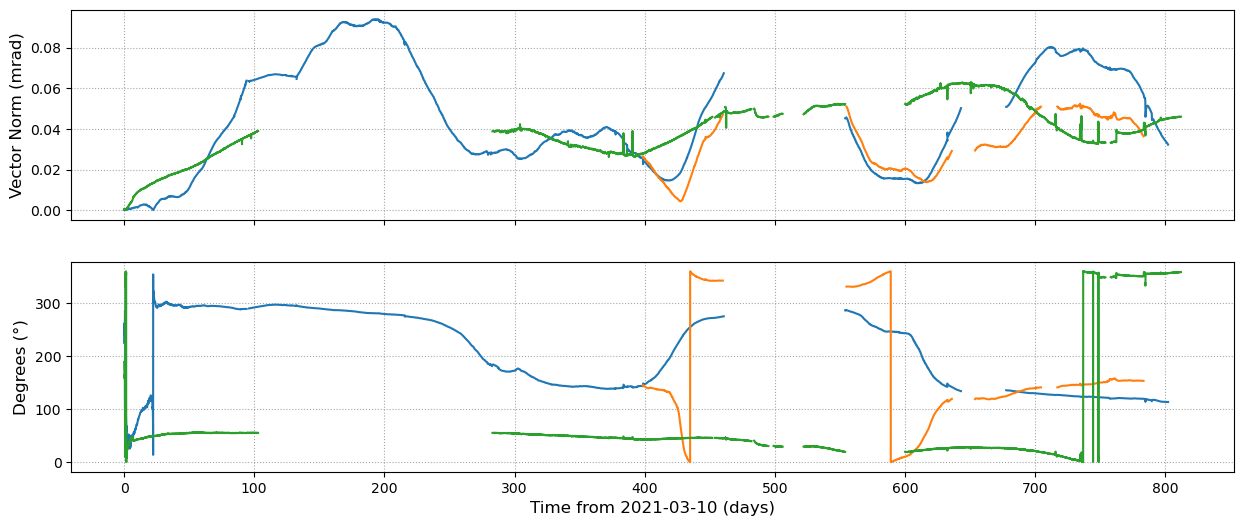

In [33]:
fig = __makeplot_vector(set1, set2, set3);

if config['save']:
    fig.savefig(config['path_to_figs']+"TILT_all_overview_movement.png", format="png", dpi=200, bbox_inches='tight')

# Plotting Rain

# OTHER

## PSD

In [34]:
def __makeplotStreamSpectra(st, fmin=None, fmax=None, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    NN = len(st)
    rot_scaling, rot_unit = 1e6, r"$\mu$rad"
    # trans_scaling, trans_unit = 1e3, r"mm/s"

    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14

    plt.subplots_adjust(hspace=0.3)

    colors = ["black", "tab:red", "tab:blue", "tab:green"]

    ## _______________________________________________

    st = st.sort(keys=['location','channel'], reverse=True)

    c = -1
    for i, tr in enumerate(st):

        if i %3 == 0:
            c+=1

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "A":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data, tr.stats.delta, window="hanning", normalize=None)


        ## _________________________________________________________________
        if tr.stats.channel[-2] == "A":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color=colors[c],
                        label='{}.{}.{}'.format(tr.stats.station, tr.stats.location, tr.stats.channel),
                        lw=1.0,
                        )
            axes[i,1].fill_between(ff, 0, spec, alpha=0.7, color=colors[c], lw=0)


        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color=colors[c],
                        label='{}.{}.{}'.format(tr.stats.station, tr.stats.location, tr.stats.channel),
                        lw=1.0,
                        )
            axes[i,1].fill_between(ff, 0, spec, alpha=0.7, color=colors[c], lw=0)


        ## _________________________________________________________________
#         if fscale == "loglog":
# #             axes[i,1].loglog(ff, spec, color='black', lw=1.0)
#             axes[i,1].fill_between(ff, 0, spec, alpha=0.7, color='black', lw=1.)

#         elif fscale == "loglin":
# #             axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
#             axes[i,1].fill_between(ff, 0, spec, alpha=0.7, color='black', lw=1.)

#         elif fscale == "linlog":
# #             axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
#             axes[i,1].fill_between(ff, 0, spec, alpha=0.7, color='black', lw=1.)

#         else:
# #             axes[i,1].plot(ff, spec, color='black', lw=1.0)
#             axes[i,1].fill_between(ff, 0, spec, alpha=0.7, color='black')


        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            sym, unit =  "Amplitude", "a.u."

        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)

        # axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        # axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axes[i,0].ticklabel_format(useOffset=False, style='plain')
        axes[i,1].ticklabel_format(useOffset=False, style='plain')

    if fmin is not None and fmax is not None:
        axes[i,1].set_xlim(fmin, fmax)

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)

    plt.tight_layout()

    return fig

In [35]:
from obspy import Stream
st = Stream()
st += TROMY.copy()
st += ROMYT.copy()
st += BROMY.copy()

st.detrend("demean")

NotImplementedError: Trace with masked values found. This is not supported for this operation. Try the split() method on Trace/Stream to produce a Stream with unmasked Traces.

In [ ]:
fig = __makeplotStreamSpectra(st, fmin=0, fmax=0.1, fscale=None)

## Other

In [ ]:
def __makeplotStreamPSD(st, config):

    from scipy import fftpack
    from numpy import abs
    from scipy.signal import welch, hann


    nblock =  4096*100
    overlap = 1028
    win = hann(nblock, True)

    fig, axes = plt.subplots(len(st),2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    for i, tr in enumerate(st):

        ff, Pxx = welch(tr.data, fs=tr.stats.sampling_rate,
                        window=win, noverlap=overlap, nfft=nblock,
                        scaling="density",
                        return_onesided=True)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times(),
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].loglog(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )


        axes[i,0].set_ylabel(r'$\Omega$ (rad/s)')
        axes[i,1].set_ylabel(r'PSD (rad$^2$/Hz)')
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,1].set_xlim(1e-7,0.25)
#         axes[i,1].set_ylim(1e-12,1e-9)

    return fig